- My own practice to implement(or copy) re-usable/probable codes from scratch. 

In [3]:
import gzip, pickle, pathlib, torch
data_path = pathlib.Path("/content/mnist.pkl.gz")

def get_data(data_path):
    with gzip.open(data_path) as f:
        (x_train, y_train), (x_valid, y_valid), (x_test, y_test)= pickle.load(f, encoding='latin-1')
        return map(torch.tensor, (x_train, y_train, x_valid, y_valid, x_test, y_test))

In [4]:
x_train, y_train, x_valid, y_valid, x_test, y_test = get_data(data_path)

In [6]:
def print_size(): [print(i) for i in map(lambda x: print(x.shape), (x_train, y_train, x_valid, y_valid, x_test, y_test))]

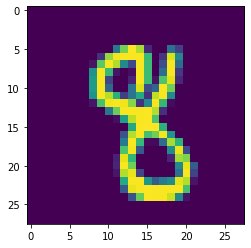

In [7]:
import matplotlib.pyplot as plt
plt.imshow(x_train[-1].view(28, -1))

`Learner`

In [ ]:
# !git clone https://github.com/fastai/course-v3
# !cat course-v3/nbs/dl2/exp/nb_01.py
# !cat course-v3/nbs/dl2/exp/nb_02.py
# !cat course-v3/nbs/dl2/exp/nb_03.py
# !cat course-v3/nbs/dl2/exp/nb_04.py


#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################
# file to edit: dev_nb/01_matmul.ipynb

from exp.nb_00 import *
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)
def test_near(a,b): test(a,b,near)
#################################################
### THIS FILE WAS AUTOGENERATED! DO NOT EDIT! ###
#################################################
# file to edit: dev_nb/02_fully_connected.ipynb

from exp.nb_01 import *

def get_data():
   

In [66]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))
    
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

# ---
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0

    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1

    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad():
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break

        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train

    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)

    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]

    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)

    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()

    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)

    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

# ---

from functools import partial
from torch.functional import F
from torch import nn, optim, tensor

In [9]:
#A0
x_train, y_train, x_valid, y_valid, x_test, y_test = get_data(data_path)
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c=c)

In [10]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [11]:
learn = create_learner(get_model, loss_func, data)

In [12]:
run = Runner(
     [
      AvgStatsCallback([accuracy])
     ]
    )

In [30]:
run.fit(epochs = 3, learn = learn)

train: [0.2091234765625, tensor(0.9397)]
valid: [0.1933284912109375, tensor(0.9451)]
train: [0.18344703125, tensor(0.9466)]
valid: [0.167803759765625, tensor(0.9531)]
train: [0.164496171875, tensor(0.9523)]
valid: [0.156703564453125, tensor(0.9570)]


In [31]:
# Why this attribute is "None"??
run.learn

---

In [18]:
# How can I know which parameters function `get_model` requires?
getmodel_params = inspect.signature(get_model).parameters
getmodel_params.items(), getmodel_params.values()

(odict_items([('data', <Parameter "data">), ('lr', <Parameter "lr=0.5">), ('nh', <Parameter "nh=50">)]),
 odict_values([<Parameter "data">, <Parameter "lr=0.5">, <Parameter "nh=50">]))

In [29]:
run.learn

In [82]:
# A1
class Recorder(Callback):
    
    def begin_fit(self):
        """when beginning fitting, intialize learning rate list and loss list to trace status of learning"""
        self.lrs, self.losses = [], []

    def after_batch(self):
        """when it's training phase, record learning rate & loss"""
        if not self.in_train: return
        # print(self.opt.params_group[-1])
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())
    
    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

In [39]:
for layer_i, pg in enumerate(learn.opt.param_groups):
    print(layer_i+1, pg.keys(), sep='\t|\t')

1	|	dict_keys(['params', 'lr', 'momentum', 'dampening', 'weight_decay', 'nesterov'])


In [71]:
class ParamScheduler(Callback):
    _order = 1
    def __init__(self, pname, sched_func): self.pname, self.sched_func = pname, sched_func

    def set_params(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs / self.epochs)
    
    def begin_batch(self):
        if self.in_train: self.set_params()

---

In [41]:
def annealer(func):
    def _inner(start, end): return partial(func, start, end)
    return _inner

In [56]:
import math

@annealer
def sched_lin(start, end, pos): return start + (end-start) * pos

@annealer
def sched_no(start, end, pos): return start

@annealer
def sched_exp(start, end, pos): return start * pow(end/start, pos)

@annealer
def sched_cos(start, end, pos): return start + (end-start)/2 * (1+ math.cos(((1-pos)*math.pi)))

In [57]:
annealings = "NO LINEAR COS EXP".split()
a = torch.arange(0, 100); a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
        54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
        72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
        90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [58]:
p = torch.linspace(0.01, 1, 100); p

tensor([0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800, 0.0900,
        0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700, 0.1800,
        0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600, 0.2700,
        0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500, 0.3600,
        0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400, 0.4500,
        0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300, 0.5400,
        0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200, 0.6300,
        0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100, 0.7200,
        0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000, 0.8100,
        0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900, 0.9000,
        0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800, 0.9900,
        1.0000])

In [59]:
fns = [sched_no, sched_lin, sched_cos, sched_exp]

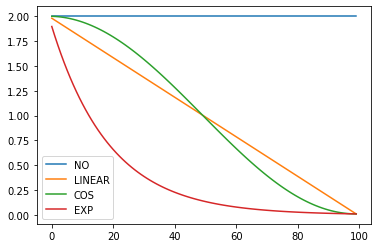

In [60]:
for fn, aname in zip(fns, annealings):
    f = fn(2, 1e-2)
    plt.plot(a, [f(tmp) for tmp in p], label=aname)
plt.legend()

In [78]:
#A4

def combine_scheds(points, schedulers):
    assert sum(points) ==1.
    points = tensor([0]+listify(points))#add 0
    assert torch.all(points >= 0)
    points = torch.cumsum(points, 0) #make cumulative sum with its dimension 0
    def _inner(pos):
        idx = (pos>=points).nonzero().max() #threshold where current position belongs
        if idx ==2: idx =1 #prevent last case (when pos = 1)
        actual_pos = (pos-points[idx]) / (points[idx+1]-points[idx])
        return schedulers[idx](actual_pos)
    return _inner

In [79]:
# 0~30% will be linear annealer from 0.3 through 0.6 and rest will be 0.6 to 0.2
sched = combine_scheds(points=[0.3, 0.7], schedulers=[sched_lin(0.3, 0.6), sched_lin(0.6, 0.2)])

In [83]:
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        partial(ParamScheduler, 'lr', sched)]

In [67]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

learn = create_learner(get_model_func(0.3), loss_func, data)

In [84]:
run = Runner(cb_funcs=cbfs)
run.fit(3, learn)

train: [0.77514765625, tensor(0.7838)]
valid: [0.315703515625, tensor(0.9093)]
train: [0.3076575390625, tensor(0.9100)]
valid: [0.2414768310546875, tensor(0.9319)]
train: [0.24628341796875, tensor(0.9301)]
valid: [0.21478974609375, tensor(0.9408)]


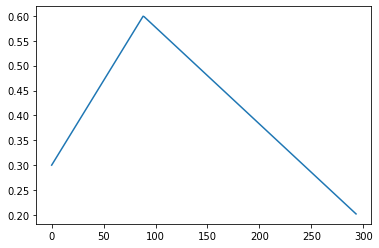

In [85]:
run.recorder.plot_lr()